In [61]:
import pandas as pd
import numpy as np
from datetime import datetime

In [62]:
%matplotlib inline

In [63]:
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('auc'))
        self.val_acc.append(logs.get('val_auc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(15,10))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="validation_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [64]:
import telepot
def send_notify(text):
    with open('../../_access_keys/telegram_token.txt', 'r') as content_file:
        token = content_file.read()
    with open('../../_access_keys/user.txt', 'r') as content_file:
        user = content_file.read()
    try:
        TelegramBot = telepot.Bot(token)
        TelegramBot.sendMessage(int(user), text)
    except:
        pass

In [65]:
TRAIN = True

In [66]:
path = 'c:/data/mlbootcamp/dataset/'
path_train = path + 'train/'
path_test = path + 'test/'
path_features = 'features/'
if TRAIN:
    pathfiles = path_train
    path_subs_bs_consumption = 'subs_bs_consumption_train.csv'
    path_subs_bs_data_session = 'subs_bs_data_session_train.csv'
    path_subs_bs_voice_session = 'subs_bs_voice_session_train.csv'
    path_subs_features = 'subs_features_train.csv'
    path_subs_csi = 'subs_csi_train.csv'
    path_new_features = 'features.csv'
else:
    pathfiles = path_test
    path_subs_bs_consumption = 'subs_bs_consumption_test.csv'
    path_subs_bs_data_session = 'subs_bs_data_session_test.csv'
    path_subs_bs_voice_session = 'subs_bs_voice_session_test.csv'
    path_subs_features = 'subs_features_test.csv'
    path_subs_csi = 'subs_csi_test.csv'
    path_new_features = 'features.csv'

In [67]:
subs_csi = pd.read_csv(pathfiles + path_subs_csi, sep=';', decimal=',')

In [68]:
subs_csi.head(1)

,SK_ID,CONTACT_DATE
0,6184,02.04


In [69]:
subs_csi.shape

(5221, 2)

In [70]:
subs_bs_consumption = pd.read_csv(pathfiles + path_subs_bs_consumption, sep=';', decimal=',')

In [71]:
subs_bs_consumption['month'] = subs_bs_consumption['MON'].apply(lambda x:int(str(x).split('.')[1]))

In [72]:
subs_bs_consumption.head(1)

,SK_ID,CELL_LAC_ID,MON,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN,month
0,6357,104453,01.02,0.0,0.0,0.000234,2


In [73]:
subs_bs_consumption.shape

(1179454, 7)

In [15]:
users = subs_csi['SK_ID'].unique()
user_summary_sum_minutes = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}
user_summary_sum_data_mb = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}
user_summary_sum_data_min = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}

In [16]:
for i in subs_bs_consumption.values:
    user_summary_sum_minutes[(i[0], i[6])] += i[3]
    user_summary_sum_data_mb[(i[0], i[6])] += i[4]
    user_summary_sum_data_min[(i[0], i[6])] += i[5]

In [74]:
subs_bs_data_session = pd.read_csv(pathfiles + path_subs_bs_data_session, sep=';', decimal=',')

In [75]:
subs_bs_data_session.head(1)

,SK_ID,CELL_LAC_ID,DATA_VOL_MB,START_TIME
0,4992,3442,0.000564,13.03 16:00:00


In [76]:
subs_bs_data_session.shape

(4138720, 4)

In [77]:
subs_features = pd.read_csv(pathfiles + path_subs_features, sep=';', decimal=',')

In [78]:
subs_features.head(1)

,SNAP_DATE,COM_CAT#1,SK_ID,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,...,COM_CAT#25,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34
0,01.10.01,8,6954,44,12,1,1,12.0,3,NaN,...,1,1,0.014411,0.036439,0.0,0.0,0.040759,0.027579,0.103896,10.0


In [79]:
subs_features.shape

(58989, 36)

In [80]:
subs_features['SNAP_DATE'] = subs_features['SNAP_DATE'].apply(lambda x:datetime.strptime(x, '%d.%m.%y'))

In [81]:
cats = subs_features['COM_CAT#24'].unique()
subs_features['COM_CAT#242'] = pd.Categorical(subs_features['COM_CAT#24'], categories=cats)
subs_features['COM_CAT#242'] = subs_features['COM_CAT#242'].cat.codes

In [82]:
subs_features['COM_CAT#34'].fillna(0, inplace=True)
subs_features['COM_CAT#8'].fillna(0, inplace=True)
subs_features['DEVICE_TYPE_ID'].fillna(0, inplace=True)
subs_features['ARPU_GROUP'].fillna(0, inplace=True)
subs_features['INTERNET_TYPE_ID'].fillna(0, inplace=True)

In [83]:
subs_features.dropna().shape

(58989, 37)

In [84]:
subs_features['month'] = subs_features['SNAP_DATE'].apply(lambda x:x.month)
subs_features['year'] = subs_features['SNAP_DATE'].apply(lambda x:x.year)

In [85]:
def get_subs_features(year, month, fix_month, day, sk_id):
    data = subs_features[(subs_features['year'] == year) & (subs_features['month'] == month) & (subs_features['SK_ID'] == sk_id)]
    columns = ['COM_CAT#1', 'COM_CAT#2', 'COM_CAT#3', 'BASE_TYPE', 'ACT', 'ARPU_GROUP', 'COM_CAT#7', 'COM_CAT#8',
              'DEVICE_TYPE_ID', 'INTERNET_TYPE_ID', 'REVENUE', 'ITC', 'VAS', 'RENT_CHANNEL', 'ROAM',
              'COST', 'COM_CAT#242']
    for i in range(18):
        if i + 17 == 24:
            if data.shape[0] == 1:
                d = data[['COM_CAT#24']].values[0].tolist()[0]
                dt = str(d).split('.')
                c_month = int(dt[1])
                c_day = int(dt[0])
                delta = (datetime(2002, fix_month, day) - datetime(2001 if d == '31.12' else 2002, c_month, c_day)).days
            continue
        columns.append('COM_CAT#{}'.format(i+17))
    if data.shape[0] == 1:
        return columns, data[columns].values[0].tolist()
    else:
        return columns, np.zeros(len(columns))

In [86]:
# for dnn
table = []
if TRAIN:
    y = np.zeros(subs_csi.shape[0])
for i in enumerate(subs_csi.values):
    sk_id = int(i[1][0])
    line = [sk_id]
    table_columns = ['sk_id']
    if TRAIN:
        dt = str(i[1][2]).split('.')
    else:
        dt = str(i[1][1]).split('.')
    year = 2002
    month = int(dt[1])
    for j in range(12):
        new_line = get_subs_features(year, month, int(dt[1]), int(dt[0]), sk_id)
        line.extend(new_line[1])
        table_columns.extend(new_line[0])
        month -= 1
        if month == 0:
            month = 12
            year -= 1
    #for j in range(3):
    #    line.append(user_summary_sum_minutes[(sk_id, int(dt[1]) - j)])
    #    line.append(user_summary_sum_data_mb[(sk_id, int(dt[1]) - j)])
    #    line.append(user_summary_sum_data_min[(sk_id, int(dt[1]) - j)])
    table.append(line)
    if TRAIN:
        y[i[0]] = i[1][1]

In [87]:
data = pd.DataFrame(data=table, columns=table_columns)

In [88]:
columns_avg = ['CELL_AVAILABILITY_2G', 'CELL_AVAILABILITY_3G',
       'CELL_AVAILABILITY_4G', 'CSSR_2G', 'CSSR_3G',
       'ERAB_PS_BLOCKING_RATE_LTE', 'ERAB_PS_BLOCKING_RATE_PLMN_LTE',
       'ERAB_PS_DROP_RATE_LTE', 'HSPDSCH_CODE_UTIL_3G',
       'NODEB_CNBAP_LOAD_HARDWARE', 'PART_CQI_QPSK_LTE', 'PART_MCS_QPSK_LTE',
       'PROC_LOAD_3G', 'PSSR_2G', 'PSSR_3G', 'PSSR_LTE',
       'RAB_CS_BLOCKING_RATE_3G', 'RAB_CS_DROP_RATE_3G',
       'RAB_PS_BLOCKING_RATE_3G', 'RAB_PS_DROP_RATE_3G', 'RBU_AVAIL_DL',
       'RBU_AVAIL_DL_LTE', 'RBU_AVAIL_UL', 'RBU_OTHER_DL', 'RBU_OTHER_UL',
       'RBU_OWN_DL', 'RBU_OWN_UL', 'RRC_BLOCKING_RATE_3G',
       'RRC_BLOCKING_RATE_LTE', 'RTWP_3G', 'SHO_FACTOR', 'TBF_DROP_RATE_2G',
       'TCH_DROP_RATE_2G', 'UTIL_BRD_CPU_3G', 'UTIL_CE_DL_3G',
       'UTIL_CE_HW_DL_3G', 'UTIL_CE_UL_3G', 'UTIL_SUBUNITS_3G',
       'UL_VOLUME_LTE', 'DL_VOLUME_LTE', 'TOTAL_DL_VOLUME_3G',
       'TOTAL_UL_VOLUME_3G']

In [89]:
columns_chhn = ['AVEUSERNUMBER', 'AVEUSERNUMBER_PLMN',
       'AVR_DL_HSPA_USER_3G', 'AVR_DL_R99_USER_3G', 'AVR_DL_USER_3G',
       'AVR_DL_USER_LTE', 'AVR_TX_POWER_3G', 'AVR_UL_HSPA_USER',
       'AVR_UL_R99_USER', 'AVR_UL_USER_3G', 'AVR_UL_USER_LTE',
       'DL_AVR_THROUGHPUT_3G', 'DL_AVR_THROUGHPUT_LTE',
       'DL_AVR_THROUGHPUT_R99', 'DL_MEAN_USER_THROUGHPUT_LTE',
       'DL_MEAN_USER_THROUGHPUT_DL_2G', 'DL_MEAN_USER_THROUGHPUT_HSPA3G',
       'DL_MEAN_USER_THROUGHPUT_PLTE', 'DL_MEAN_USER_THROUGHPUT_REL93G',
       'HSDPA_USERS_3G', 'HSUPA_USERS_3G', 'RBU_USED_DL', 'RBU_USED_UL',
       'RELATIVE_RBU_USED_DL', 'RELATIVE_RBU_USED_UL', 'RELATIVE_TX_POWER_3G',
       'UL_AVR_THROUGHPUT_3G', 'UL_AVR_THROUGHPUT_LTE',
       'UL_AVR_THROUGHPUT_R99', 'UL_MEAN_USER_THROUGHPUT_LTE',
       'UL_MEAN_USER_THROUGHPUT_HS3G', 'UL_MEAN_USER_THROUGHPUT_PLTE',
       'UL_MEAN_USER_THROUGHPUT_REL93G']

In [90]:
def get_extend_data(type_data, column_name):
    fname = pathfiles + path_features + '{}_{}.csv'.format(type_data, column_name)
    result = pd.read_csv(fname)
    cust_columns = result.columns[:1 + 8 * 15]
    return result[cust_columns]

def get_all_data():
    result = None
    for columns in [columns_avg, columns_chhn]:
        for c in columns:
            for type_data in ['data', 'voice']:
                t = get_extend_data(type_data, c)
                if result is None:
                    result = t
                else:
                    result = result.merge(t, how='inner', left_on='sk_id', right_on='sk_id')
    return result

In [91]:
#d = get_extend_data('voice', 'UL_MEAN_USER_THROUGHPUT_REL93G')
#d.head()

In [92]:
data.head()

,sk_id,COM_CAT#1,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,DEVICE_TYPE_ID,...,COM_CAT#25,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34
0,6184,4.0,50.0,5.0,2.0,1.0,8.0,2.0,136.0,5.0,...,1.0,1.0,0.002392,0.005215,0.000001,0.00000,0.011418,0.027579,0.103896,3.0
1,5175,3.0,24.0,5.0,2.0,1.0,9.0,1.0,149.0,5.0,...,1.0,1.0,0.021598,0.049949,0.055215,0.00023,0.050353,0.027579,0.103896,2.0
2,5478,6.0,55.0,5.0,2.0,1.0,5.0,3.0,1277.0,5.0,...,1.0,1.0,0.048660,0.000296,0.000000,0.00000,0.108520,0.027579,0.103896,7.0
3,7807,6.0,71.0,11.0,1.0,1.0,6.0,3.0,139.0,5.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
4,5640,8.0,40.0,5.0,2.0,1.0,12.0,1.0,1279.0,5.0,...,1.0,1.0,0.017621,0.013507,0.009411,0.00000,0.129603,0.027579,0.103896,2.0


In [93]:
ext_data = get_all_data()

In [94]:
ext_data.shape

(5221, 18001)

In [95]:
ext_data.head()

,sk_id,0 sum_x,0 count_x,0 min_x,0 avg_x,0 max_x,0 mina_x,0 avga_x,0 maxa_x,1 sum_x,...,13 avga_y,13 maxa_y,14 sum_y,14 count_y,14 min_y,14 avg_y,14 max_y,14 mina_y,14 avga_y,14 maxa_y
0,6184,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.001259,...,0.000330,0.000837,0.057361,8.0,0.000417,0.000507,0.000704,0.000417,0.000507,0.000704
1,5175,0.003964,9.0,0.0,0.002631,0.593788,0.0,0.002631,0.593788,0.005425,...,0.000081,0.001065,0.028750,3.0,0.000000,0.000005,0.000011,0.000000,0.000005,0.000011
2,5478,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,7807,0.004961,3.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.014308,...,0.000891,0.001123,0.076944,3.0,0.000355,0.000483,0.000546,0.000355,0.000483,0.000546
4,5640,0.005344,3.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.098175,...,0.000310,0.000630,0.057639,5.0,0.000260,0.000469,0.000572,0.000321,0.000473,0.000572


In [96]:
res_data = data.merge(ext_data, how='inner', left_on='sk_id', right_on='sk_id')

In [97]:
res_data.drop(['sk_id'], axis=1, inplace=True)

In [98]:
res_data.tail()

,COM_CAT#1,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,...,13 avga_y,13 maxa_y,14 sum_y,14 count_y,14 min_y,14 avg_y,14 max_y,14 mina_y,14 avga_y,14 maxa_y
5216,1.0,30.0,5.0,2.0,1.0,9.0,1.0,184.0,5.0,2.0,...,0.000068,0.000087,0.257708,5.0,0.000060,0.000114,0.000181,0.000060,0.000076,0.000094
5217,4.0,5.0,2.0,2.0,1.0,10.0,2.0,1322.0,5.0,2.0,...,0.000464,0.000601,0.135208,6.0,0.000000,0.000057,0.000616,0.000000,0.000057,0.000616
5218,5.0,48.0,5.0,2.0,1.0,1.0,4.0,0.0,3.0,3.0,...,0.000000,0.000000,0.230278,2.0,0.000171,0.000171,0.000171,0.000000,0.000000,0.000000
5219,1.0,30.0,5.0,2.0,1.0,12.0,1.0,795.0,5.0,2.0,...,0.000042,0.000054,0.158958,11.0,0.000026,0.000096,0.000243,0.000026,0.000093,0.000243
5220,4.0,54.0,5.0,2.0,1.0,1.0,3.0,1324.0,5.0,2.0,...,0.000000,0.000000,0.026389,2.0,0.000000,0.000334,0.000571,0.000000,0.000334,0.000571


In [99]:
res_data.fillna(0, inplace=True)

In [100]:
from sklearn import preprocessing

In [101]:
if TRAIN:
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(res_data.values)
    res_data = pd.DataFrame(x_scaled)
else:
    x_scaled = min_max_scaler.transform(res_data.values)
    res_data = pd.DataFrame(x_scaled)

In [102]:
X = np.asarray(res_data)
y = np.asarray(y)

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [47]:
from sklearn.metrics import roc_auc_score
from keras import regularizers

In [48]:
from sklearn import metrics
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [49]:
def create_dnn_model():
    #build Keras model
    
    model = Sequential()

    model.add(Dense(1024, input_shape=(X.shape[1],), activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation="relu", kernel_initializer="uniform", kernel_regularizer=regularizers.l2(0.001)))

    
    model.add(Dense(1, activation="sigmoid", kernel_initializer="uniform"))

    model.compile(loss='binary_crossentropy', metrics=[auc], optimizer='adam')
    return model

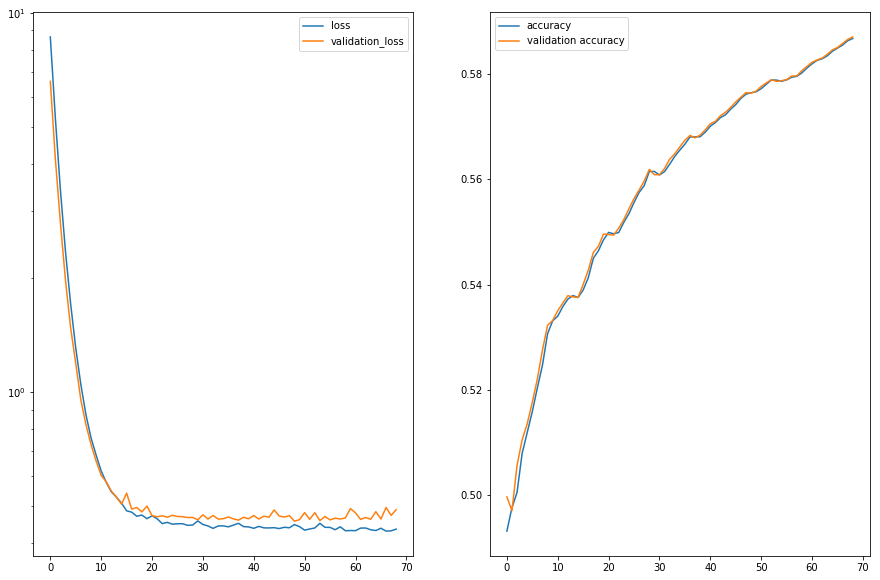

3377/3377 [==============================] - 18s 5ms/step - loss: 0.4356 - auc: 0.5867 - val_loss: 0.4903 - val_auc: 0.5870


In [58]:
count_epochs = 100
model = create_dnn_model()
early_stopping_monitor = EarlyStopping(patience=20)
history = model.fit(np.array(X), np.array(y), batch_size = 128, epochs = count_epochs, verbose=1, validation_split=0.2, class_weight=class_weights, callbacks=[plot,early_stopping_monitor])

In [105]:
send_notify('Complete fit')

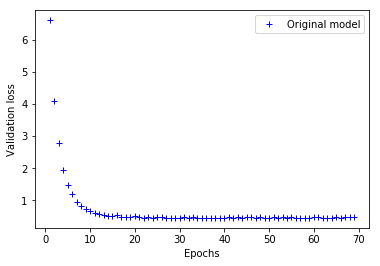

In [59]:
epochs = range(1, 69 + 1)
history_gr = history.history['val_loss']
import matplotlib.pyplot as plt

plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [57]:
predict = model.predict(np.array(X_test))
score = roc_auc_score(y_test, predict)
print("Total roc auc score = {0:0.4f}".format(score))

Total roc auc score = 0.5192


In [60]:
model_json = model.to_json()
# Записываем модель в файл
json_file = open("sale_model.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("sale_model.h5")

In [103]:
def save_predict(predict):
    with open('first.csv', 'w') as f:
        for item in predict:
            f.write("%s\n" % item[0])

In [104]:
save_predict(model.predict(np.array(X)))